# Make Summary Plots



## Python stuff

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import sys, os, copy
import importlib as imp
import gc
import pickle

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
import seaborn as sns

import regionmask
import experiment_settings
import file_methods, plots, data_processing

import matplotlib as mpl
import cartopy as ct
import cartopy.feature as cfeature

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
# plt.style.use("seaborn-v0_8-notebook")
# np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import warnings

warnings.filterwarnings("ignore")

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"tensorflow version = {tf.__version__}")
print(f"tensorflow-probability version = {tfp.__version__}")

python version = 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) 
[Clang 14.0.6 ]
numpy version = 1.24.4
xarray version = 2022.9.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
PARENT_EXP_NAME = "exp134"
EXP_SUFFIX = ""  # "_3thresholds"
RNG_SEED = 66

IPCC_REGION_EXAMPLE = "WNA"
EVAL_THRESHOLD = 2.0

# IPCC_REGION_EXAMPLE = "CNA"
# EVAL_THRESHOLD = 3.0

# -------------------------------------------------------
settings = experiment_settings.get_settings(PARENT_EXP_NAME)
settings["target_temp"] = EVAL_THRESHOLD
# -------------------------------------------------------

MODEL_DIRECTORY = "saved_models/"
PREDICTIONS_DIRECTORY = "saved_predictions/"
DATA_DIRECTORY = (
    "../../../2022/target_temp_detection/data/"  # point to where your data is sitting
)
OBS_DIRECTORY = "../data/"
GCM_DATA_DIRECTORY = "../data/"
DIAGNOSTICS_DIRECTORY = "model_diagnostics/"
FIGURE_DIRECTORY = "figures/"

## Example prediction

In [4]:
imp.reload(data_processing)

# get the slopes from the stored pickle dictionaries of metrics
settings_obs = settings.copy()
settings_obs["target_region"] = None
settings_obs["obs_training_only"] = True

da_obs, x_obs, global_mean_obs = data_processing.get_observations(
    OBS_DIRECTORY, settings_obs
)
mask = regionmask.defined_regions.ar6.land.mask(da_obs)

ar6_land = regionmask.defined_regions.ar6.land
IPCC_REGION_LIST = ar6_land.abbrevs
REMOVE_REG_LIST = ("GIC", "EAN", "WAN")
# REMOVE_REG_LIST = ()

# initialize the matrics
test_metrics_matrix = np.zeros((len(IPCC_REGION_LIST), 3)) * np.nan
map_test_error = np.zeros(mask.shape) * np.nan

# loop and load the data for each region
for ireg, ipcc_region in enumerate(IPCC_REGION_LIST):
    settings = experiment_settings.get_settings(PARENT_EXP_NAME)
    settings["target_temp"] = EVAL_THRESHOLD
    settings["rng_seed"] = RNG_SEED
    settings["exp_name"] = PARENT_EXP_NAME + "_" + ipcc_region
    settings["target_region"] = "ipcc_" + ipcc_region
    model_name = file_methods.get_model_name(settings)

    # get base model metrics
    try:
        df_metrics = pd.read_pickle(
            PREDICTIONS_DIRECTORY + model_name + "_metrics.pickle"
        )
    except:
        continue

    if ipcc_region != IPCC_REGION_EXAMPLE:
        test_metrics_matrix[ireg, :] = np.nan
    else:
        test_metrics_matrix[ireg, 0] = df_metrics["loss_test"][0]
        test_metrics_matrix[ireg, 1] = df_metrics["error_test"][0]
        test_metrics_matrix[ireg, 2] = df_metrics["d_valtest"][0]

    map_test_error = np.where(
        mask != ireg, map_test_error, test_metrics_matrix[ireg, 1]
    )

print(
    "\nPercent Complete = "
    + str(
        np.round(
            100.0
            * np.count_nonzero(~np.isnan(test_metrics_matrix[:, 0]))
            / (test_metrics_matrix.shape[0] - len(REMOVE_REG_LIST)),
            1,
        )
    )
    + "%\n"
)

observations: filling NaNs with zeros
np.shape(x_obs) = (54, 72, 144, 1)
np.shape(data_obs) = (54, 72, 144)

Percent Complete = 2.3%



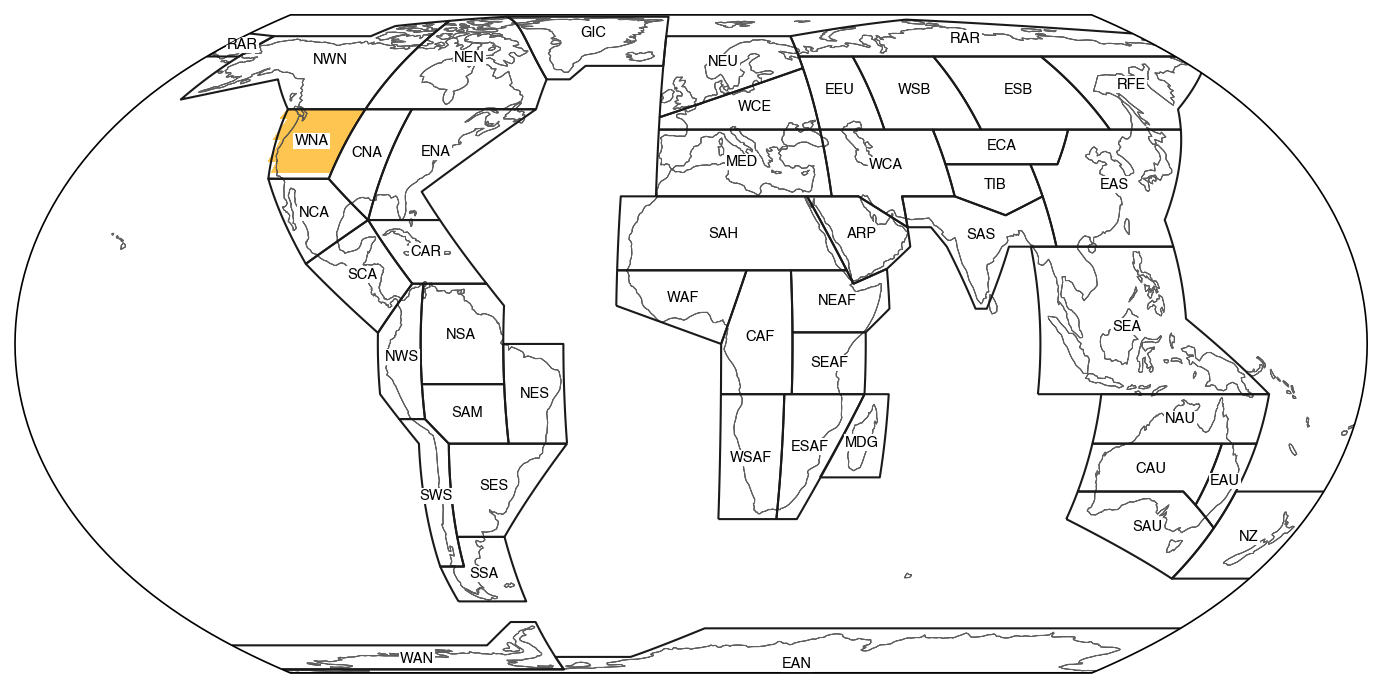

In [5]:
imp.reload(plots)

# plot the slopes
transform = ct.crs.PlateCarree()
projection = ct.crs.EqualEarth(central_longitude=0.0)
FS = 9
fig = plt.figure(figsize=(1.25 * 5.5 * 2, 1.25 * 3.75))

# -------------
a1 = fig.add_subplot(1, 1, 1, projection=projection)
cmap, cb_bounds = plt.cm.YlOrBr, [0.5, 8.5, 1.0]
clr_norm = plots.get_discrete_colornorm(cb_bounds, cmap)
c1 = a1.pcolormesh(
    da_obs.lon,
    da_obs.lat,
    map_test_error,
    cmap=cmap,
    transform=transform,
    norm=clr_norm,
)
a1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "110m", edgecolor="k", linewidth=0.5, facecolor="None"
    )
)
c1.set_clim(0, 8)
# cb = fig.colorbar(
#     c1,
#     orientation="horizontal",
#     shrink=0.25,
#     extend="max",
#     pad=0.02,
# )
# cb.set_label(
#     label="years",
#     fontsize=FS,
# )
# cb.ax.tick_params(labelsize=FS)
# cb.ax.set_xticks(np.arange(0, 8 + 1))

text_kws = dict(color="k", fontsize=7, bbox=dict(pad=0.1, color="w"))
regionmask.defined_regions.ar6.land.plot(
    add_label=True,
    text_kws=text_kws,
    label="abbrev",
    label_multipolygon="all",
    add_ocean=False,
    ocean_kws=dict(color="lightblue", alpha=0.25),
    line_kws=dict(
        linewidth=1.0,
    ),
)

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY + "example_prediction_reg_" + IPCC_REGION_EXAMPLE,
    dpi=savefig_dpi,
)
plt.show()
# plt.close()

In [6]:
# files created in _transfer_shap.ipynb

# ------------------------------------------------------
# LOAD BASE MODEL PREDICTIONS
filename = (
    PREDICTIONS_DIRECTORY
    + PARENT_EXP_NAME
    + "_rng_seed"
    + str(settings["rng_seed"])
    + "_observations_"
    + str(settings["final_year_of_obs"])
    + "_predictions_base"
    + EXP_SUFFIX
    + ".pickle"
)
with open(filename, "rb") as f:
    (obs_base_dict,) = pickle.load(f)
obs_base = obs_base_dict[settings["target_temp"]]

# ------------------------------------------------------
# LOAD TRANSFER MODEL PREDICTIONS
filename = (
    PREDICTIONS_DIRECTORY
    + PARENT_EXP_NAME
    + "_rng_seed"
    + str(settings["rng_seed"])
    + "_observations_"
    + str(settings["final_year_of_obs"])
    + "_predictions_transfer"
    + EXP_SUFFIX
    + ".pickle"
)
with open(filename, "rb") as f:
    (obs_transfer_dict,) = pickle.load(f)
obs_transfer = obs_transfer_dict[settings["target_temp"]]

[1.64529026 3.43455935]
2024.6452902555466


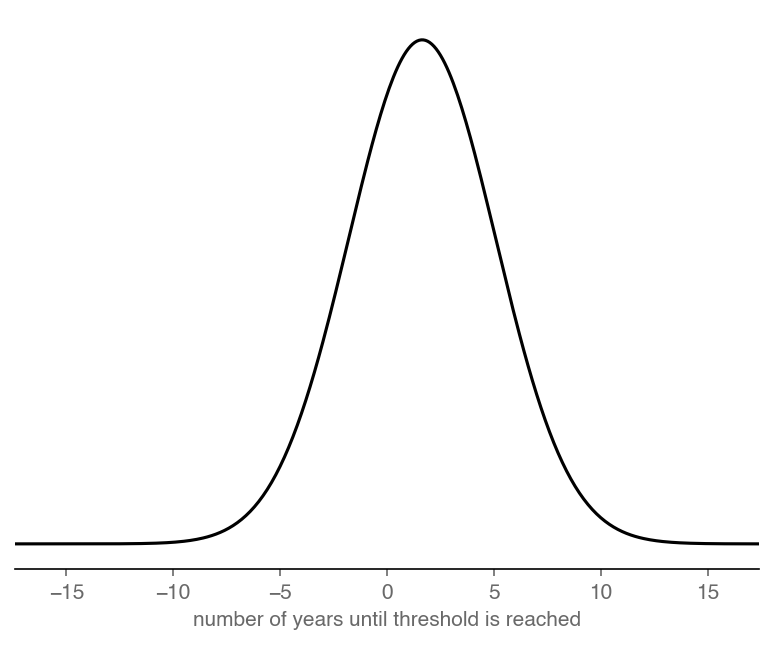

In [9]:
ireg = IPCC_REGION_LIST.index(IPCC_REGION_EXAMPLE)
print(obs_transfer[ireg, :])
print(obs_transfer[ireg, 0] + 2023)

from scipy.stats import norm

x = np.arange(-20, 60, 0.1)
y = norm.pdf(x, loc=obs_transfer[ireg, 0], scale=obs_transfer[ireg, 1])
plt.plot(x, y, "-k")
# plt.xlim(0.01, 34.9)
if IPCC_REGION_EXAMPLE == "CNA":
    plt.xlim(0.01, 34.9)
else:
    plt.xlim(-17.4, 17.4)
plt.gca().yaxis.set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xlabel("number of years until threshold is reached")
plots.savefig(
    FIGURE_DIRECTORY + "example_prediction_" + IPCC_REGION_LIST[ireg],
    dpi=savefig_dpi,
)

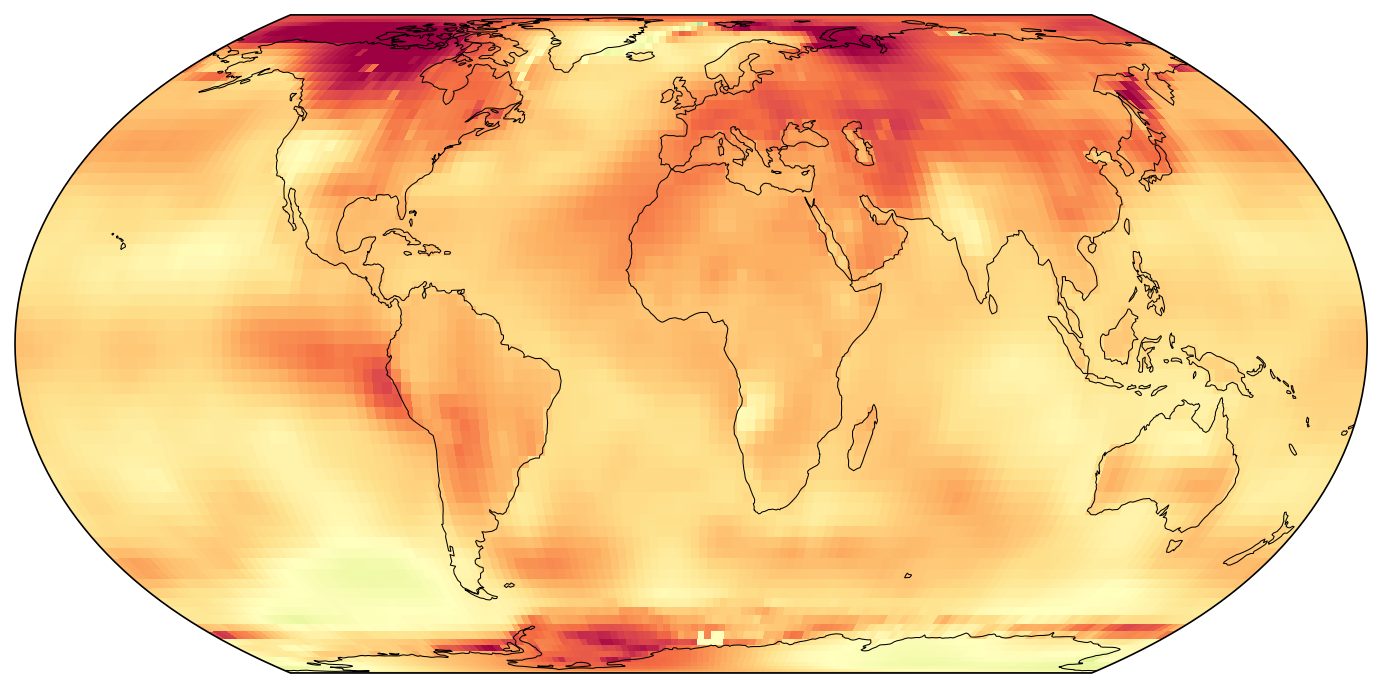

In [8]:

settings_obs["obs_training_only"] = True
__, x_obs, global_mean_obs = data_processing.get_observations(
    OBS_DIRECTORY, settings_obs, verbose=False
)
settings_obs["obs_training_only"] = False

imp.reload(plots)

# plot the slopes
transform = ct.crs.PlateCarree()
projection = ct.crs.EqualEarth(central_longitude=0.0)
FS = 9
fig = plt.figure(figsize=(1.25 * 5.5 * 2, 1.25 * 3.75))

# -------------
a1 = fig.add_subplot(1, 1, 1, projection=projection)
cmap = "Spectral_r"
# cmap, cb_bounds = plt.cm.YlOrBr, [0.5, 8.5, 1.0]
# clr_norm = plots.get_discrete_colornorm(cb_bounds, cmap)
c1 = a1.pcolormesh(
    da_obs.lon,
    da_obs.lat,
    # da_obs[-1,:,:],
    x_obs[-1, :, :, 0],
    cmap=cmap,
    transform=transform,
    # norm=clr_norm,
)
a1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "110m", edgecolor="k", linewidth=0.5, facecolor="None"
    )
)
c1.set_clim(-4, 4)

plt.tight_layout()

plots.savefig(
    FIGURE_DIRECTORY
    + PARENT_EXP_NAME
    + "example_map_" + IPCC_REGION_LIST[ireg],
    dpi=savefig_dpi,
)

plt.show()